class 1
class 2
class 3
class 4
class 5
class 6
class 7
class 8
class 9
class 10
class 11
class 12
class 13
class 14
class 15
class 16
class 17
class 18
class 19
class 20


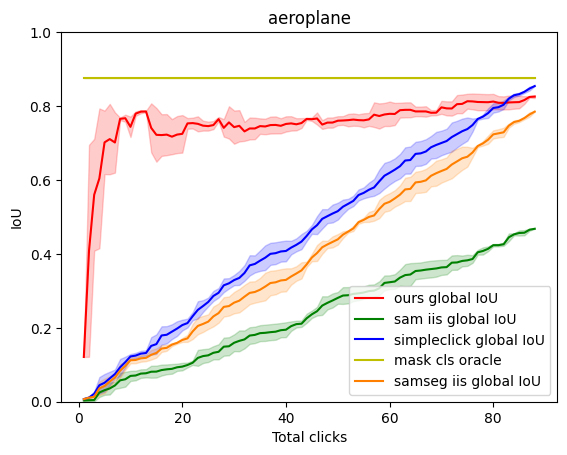

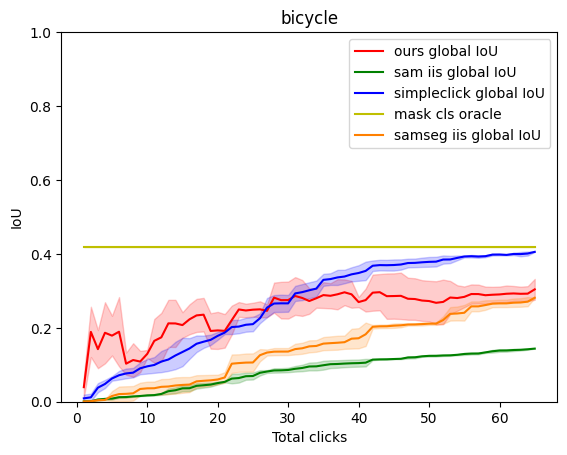

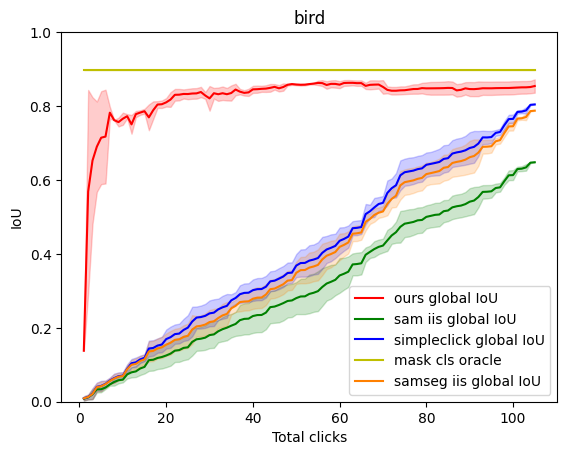

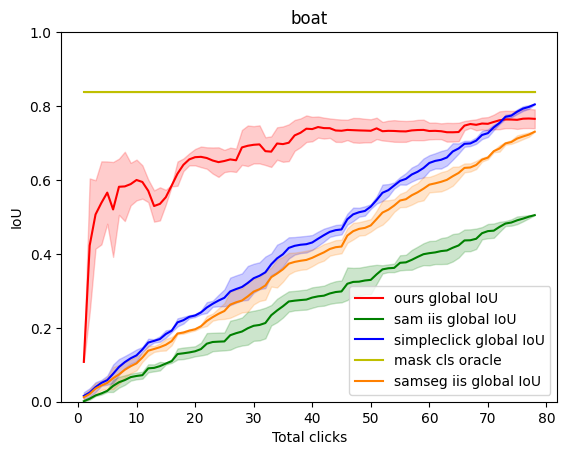

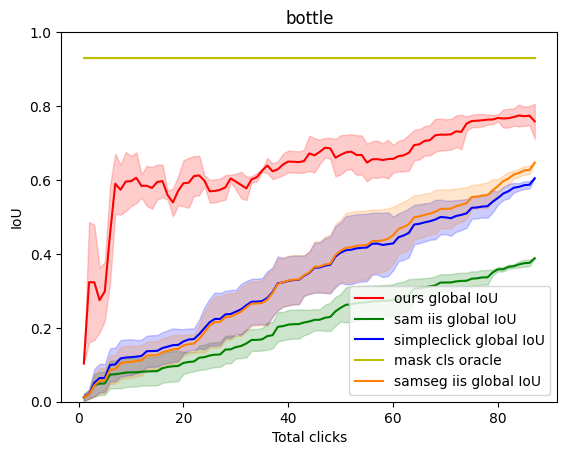

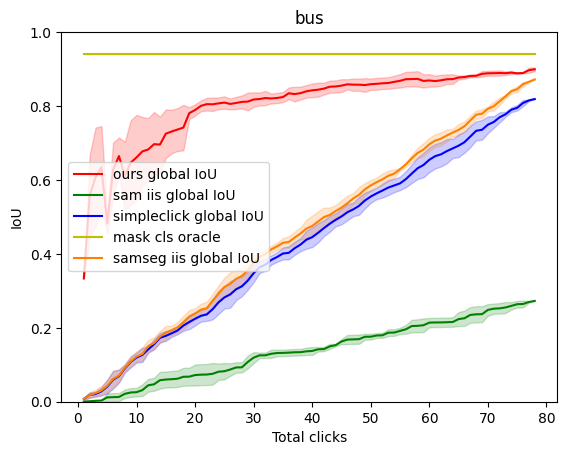

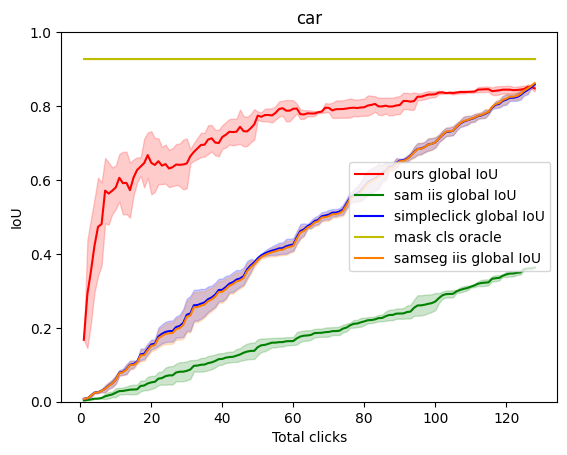

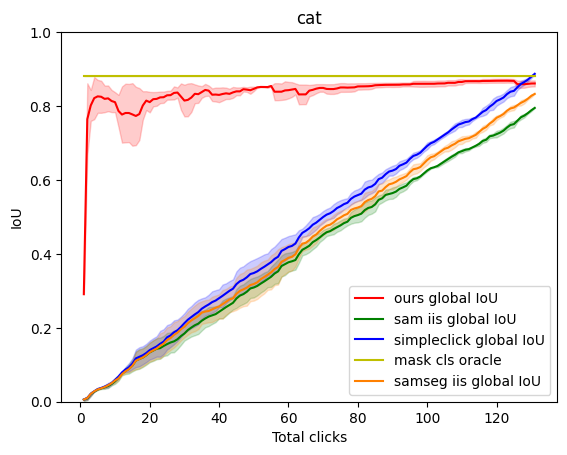

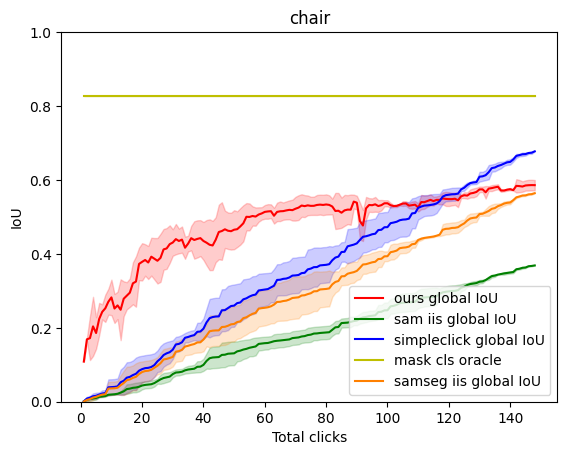

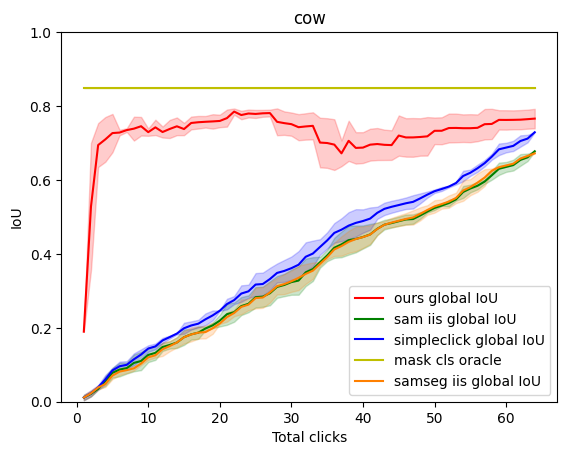

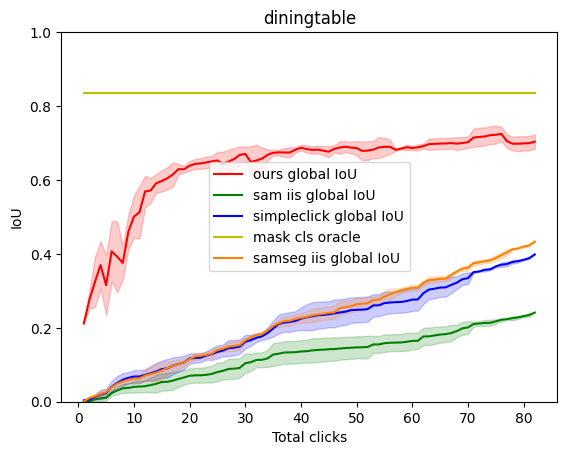

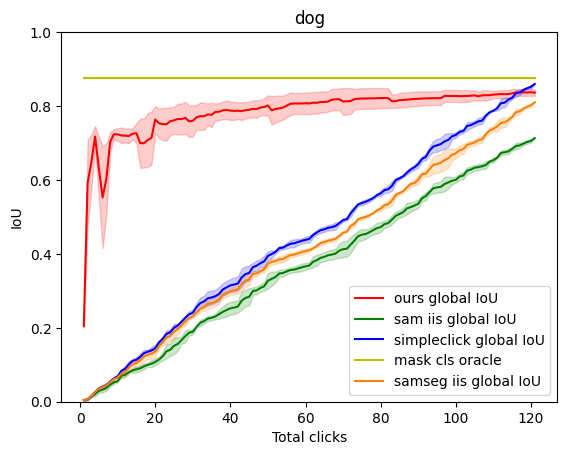

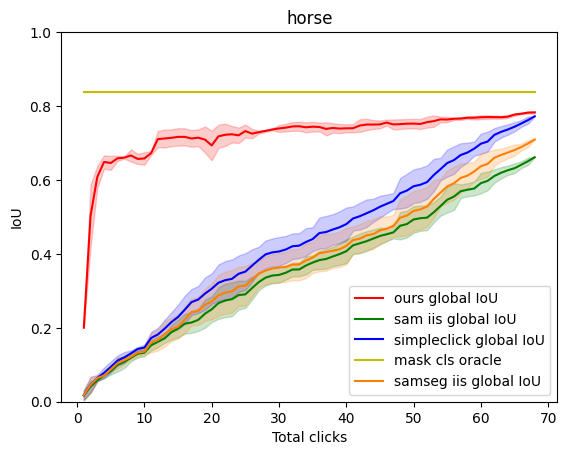

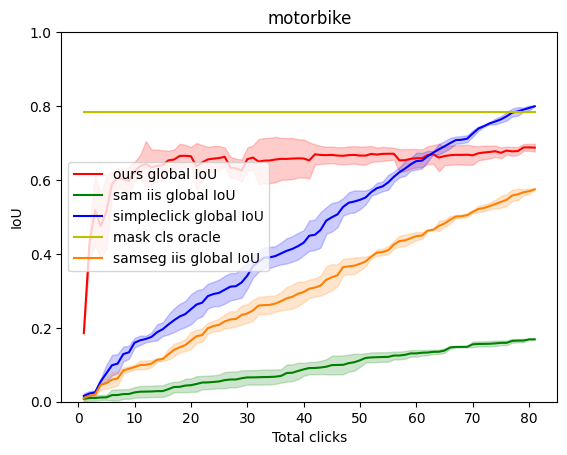

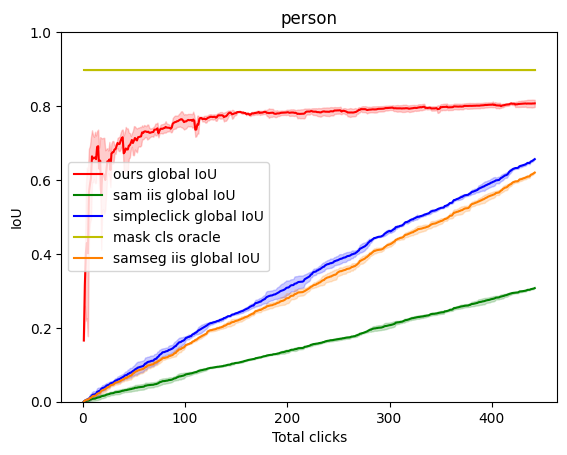

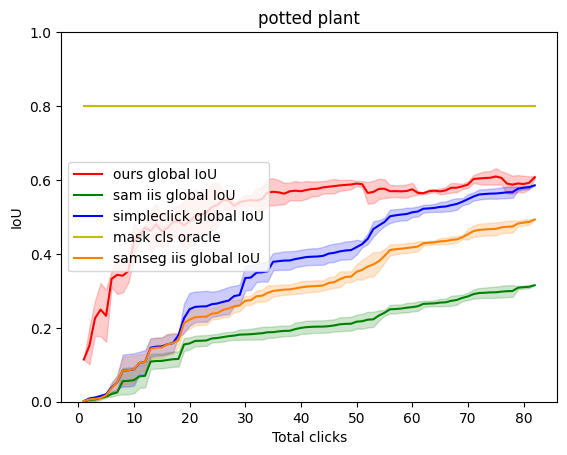

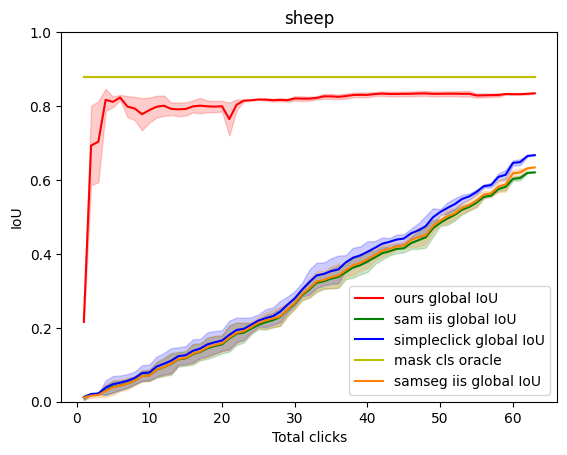

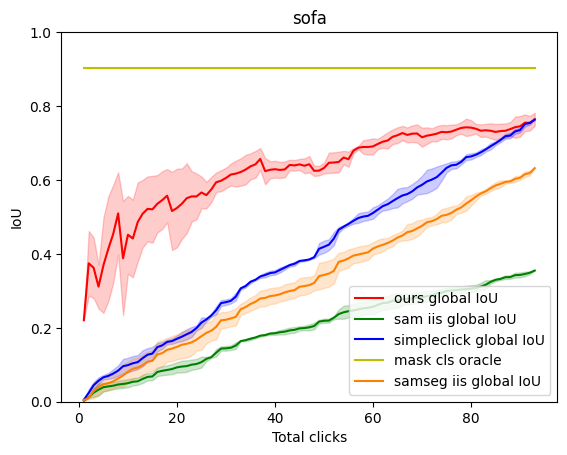

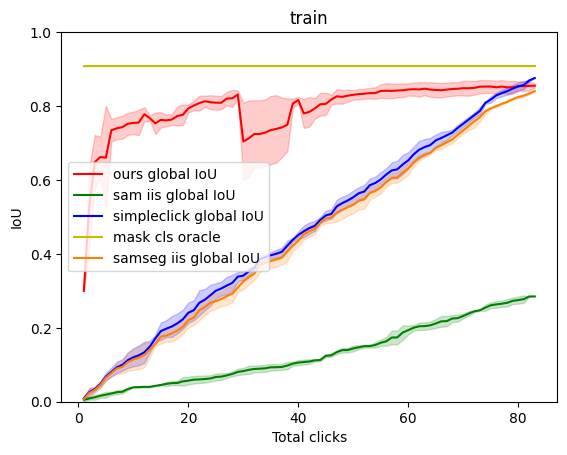

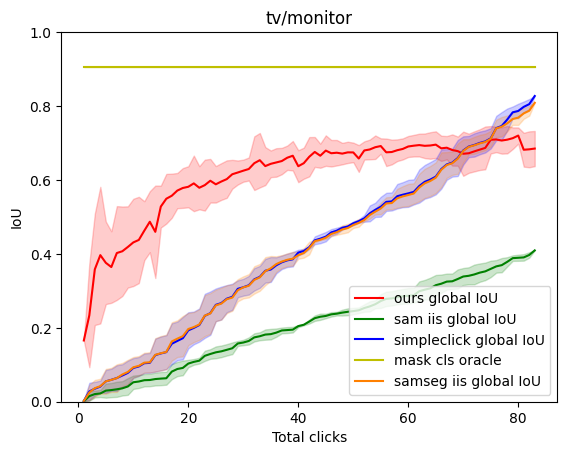

In [1]:
import os
import numpy as np
import ast
import json
import matplotlib.pyplot as plt
import sys
from pathlib import Path
sys.path.append('..')
from dataloaders.pascalvoc import classes
from metrics import aggregate_metrics
from pprint import pprint


mIoU = []
oracles = []
final_training_perf = []
overall_mean = []
curves_to_draw_per_class = []
for ind in range(1, 21):
  curves_to_draw = []
  print('class', ind)
  for seed in range(3):
    pascal_class = list(classes.keys())[ind]

    run_path = Path(f'../runs/iiss_all1x_seed{seed}/{pascal_class}/')
    metrics_path = run_path / 'metrics'
    training_res_path = run_path / 'metrics_vs_t.json'

    metric_name = 'jacc'

    ann_points_x, ann_points_y, gen_points_y = [], [], []
    for c_ind, metric in enumerate(sorted(os.listdir(metrics_path))):
        met_list_dict = json.load(open(os.path.join(metrics_path, metric)))
        ious = [d[metric_name] for d in met_list_dict]
        assert len(ious) == 2
        ann_points_x.append(c_ind+1)
        ann_points_y.append(ious[1])
        gen_points_y.append(ious[0])
    ann_points_x = np.array(ann_points_x)

    # read training res with ast
    with open(training_res_path, 'r') as f:
        training_res = ast.literal_eval(f.read())
    training_metrics = [aggregate_metrics(train_res_i) for train_res_i in training_res]

    iis_curve_path = f'../runs/sam_iis_oneimageatatime_N1464/curves_seed{seed}/curve_class{str(ind-1).zfill(2)}.json'
    with open(iis_curve_path) as f:
        iis_curve = ast.literal_eval(f.read())

    simpleclick_curve_path = f'../SimpleClick/simpleclick_oneimageatatime_N1464/curves_seed{seed}/curve_class{str(ind-1).zfill(2)}.json'
    with open(simpleclick_curve_path) as f:
        simpleclick_curve = ast.literal_eval(f.read())

    samseg_iis_curve_path = f'../runs/samseg_iis_oneimageatatime_N1464/curves_seed{seed}/curve_class{str(ind-1).zfill(2)}.json'
    with open(samseg_iis_curve_path) as f:
        samseg_iis_curve = ast.literal_eval(f.read())

    oracle_res_path = f"../runs/oracle/{pascal_class}/metrics.json"
    oracle_res = json.load(open(oracle_res_path))

    curves_to_draw.append((#ann_points_y, gen_points_y,
       [m[metric_name] for m in training_metrics], [m[metric_name] for m in iis_curve[1:]], [m[metric_name] for m in simpleclick_curve[1:]], [oracle_res[metric_name]]*len(gen_points_y),
       [m[metric_name] for m in samseg_iis_curve[1:]]))

    curves_to_draw_per_class.append(curves_to_draw)


  plt.figure()
  # plot mean and std
  for plot_ind, c, label in zip(list(range(7)), ['r', 'g', 'b', 'y', (1., .5, 0), 'k', 'c'], [#'ours annotated IoU', 'ours generalization IoU',
     'ours global IoU', 'sam iis global IoU', 'simpleclick global IoU', 'mask cls oracle', 'samseg iis global IoU']):
    mean_curve = np.array([seed_point[plot_ind] for seed_point in curves_to_draw]).mean(axis=0)
    std_curve = np.array([seed_point[plot_ind] for seed_point in curves_to_draw]).std(axis=0)
    plt.plot(ann_points_x, mean_curve, c=c, label=label)
    plt.fill_between(ann_points_x, mean_curve-std_curve, mean_curve+std_curve, alpha=0.2, color=c)

  plt.title(f'{pascal_class}')
  plt.ylabel('IoU')
  plt.xlabel('Total clicks')
  plt.ylim(0, 1)
  plt.legend()


Text(0.5, 0, '% of clicked images')

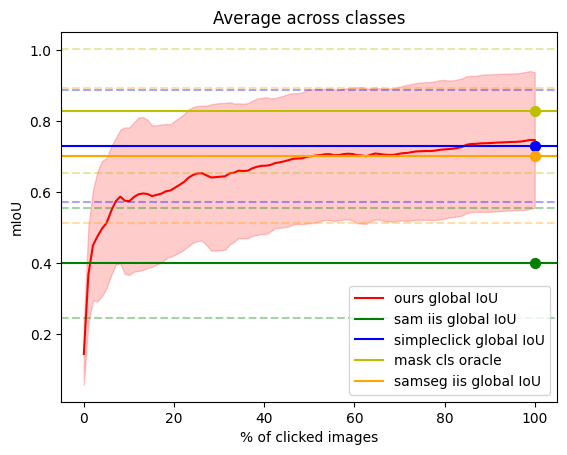

In [7]:
curves_to_draw_per_class = [[[c for c in curv] for curv in curve] for curve in curves_to_draw_per_class]  # make nested list
# indices are class, seed, curve, point
# for the curves 1, 2, 3, 4 we take the mean of the last value across seeds, and then we take the mean and std across classes
mean_std_per_curve = []
for curve_k in [1, 2, 3, 4]:
    mean_per_class = []
    for class_i in range(20):
        val_per_seed = []
        for seed_j in range(3):
            val_per_seed.append(curves_to_draw_per_class[class_i][seed_j][curve_k][-1])
        mean_per_class.append(np.mean(val_per_seed))
    mean_std_per_curve.append((np.mean(mean_per_class), np.std(mean_per_class)))

# for the curve 0 we interpolate the lists so they have the same length (100) 
# and then we take the mean and std across classes
mean_per_class = [
np.mean([curves_to_draw_per_class[class_i][seed_j][0] for seed_j in range(3)], axis=0)  # mean per class
for class_i in range(20)]
# interpolate
mean_per_class = [np.interp(np.linspace(0, 100, 100), np.linspace(0, 100, len(curve)), curve) for curve in mean_per_class]
# take mean and std
mean_std_curve0 = (np.mean(mean_per_class, axis=0), np.std(mean_per_class, axis=0))

# now plot the curve 0 and then the other ones as horizontal lines
plt.figure()
plt.plot(np.linspace(0, 100, 100), mean_std_curve0[0], c='r', label='ours global IoU')
plt.fill_between(np.linspace(0, 100, 100), mean_std_curve0[0]-mean_std_curve0[1], mean_std_curve0[0]+mean_std_curve0[1], alpha=0.2, color='r')
for curve_k, label, c in zip([1, 2, 3, 4], ['sam iis global IoU', 'simpleclick global IoU', 'mask cls oracle', 'samseg iis global IoU'], ['g', 'b', 'y', 'orange']):
    plt.axhline(y=mean_std_per_curve[curve_k-1][0], color=c, linestyle='-', label=label)
    plt.axhline(y=mean_std_per_curve[curve_k-1][0]+mean_std_per_curve[curve_k-1][1], color=c, linestyle='--', alpha=0.35)
    plt.axhline(y=mean_std_per_curve[curve_k-1][0]-mean_std_per_curve[curve_k-1][1], color=c, linestyle='--', alpha=0.35)
    plt.scatter([100], [mean_std_per_curve[curve_k-1][0]], color=c, marker='o', s=50)
plt.title(f'Average across classes')
plt.legend()
plt.ylabel('mIoU')
plt.xlabel('% of clicked images')